In [667]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import math

In [668]:
#Reading data
#Spanish data from spanish health ministry, all hisotrical series
data = pd.read_csv(r"https://covid19.isciii.es/resources/serie_historica_acumulados.csv",skipfooter=3,error_bad_lines=False,encoding = 'ANSI')

data.columns = ['CCAA Codigo ISO','Fecha','Casos','Hospitalizados','UCI','Fallecidos','Recuperados']
#World data from Johns Hopkins University (github)
#Confirmed cases
data_jh_conf = pd.read_csv(r"https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv", 
                           error_bad_lines=False,encoding = 'ANSI')

#Confirmed deaths
data_jh_muertos = pd.read_csv(r"https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv", 
                           error_bad_lines=False,encoding = 'ANSI')

#Confirmed recovered
data_jh_recuperados = pd.read_csv(r"https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv", 
                           error_bad_lines=False,encoding = 'ANSI')

#Cataluña data
data_cat = pd.read_csv(r"https://analisi.transparenciacatalunya.cat/api/views/jj6z-iyrp/rows.csv?accessType=DOWNLOAD&bom=true&format=true&delimiter=%3B&sorting=true", sep=";",encoding = 'utf-8')

#Spanish data from Madrid
data_madrid = pd.read_csv(r"https://datos.comunidad.madrid/catalogo/dataset/7da43feb-8d4d-47e0-abd5-3d022d29d09e/resource/b2a3a3f9-1f82-42c2-89c7-cbd3ef801412/download/covid19_tia_muni_y_distritos.csv", sep=";",encoding = 'ANSI')

#datos de renta por municipios
data_renta_municipios = pd.read_csv(r"C:\Users\guillermo.arguello\Documents\Covid Analisys\renta_municipios.csv", sep="|",encoding = 'ANSI')


In [669]:
#Transpose Johns Hopkins Data

data_jh_conf = data_jh_conf.melt(['Province/State', 'Country/Region',"Lat","Long"], var_name='Fecha', value_name='Casos')
data_jh_muertos = data_jh_muertos.melt(['Province/State', 'Country/Region',"Lat","Long"], var_name='Fecha', value_name='Fallecidos')
data_jh_recuperados = data_jh_recuperados.melt(['Province/State', 'Country/Region',"Lat","Long"], var_name='Fecha', value_name='Recuperados')

#Join all data in one dataframe
data_jh = pd.merge(data_jh_conf, data_jh_muertos, left_on=['Province/State','Country/Region','Fecha','Lat','Long'], 
                   right_on = ['Province/State','Country/Region','Fecha','Lat','Long'])

data_jh = pd.merge(data_jh, data_jh_recuperados, how= 'left',left_on=['Province/State','Country/Region','Fecha','Lat','Long'], 
                   right_on = ['Province/State','Country/Region','Fecha','Lat','Long'])

#Removing Province/State, Lat and long data, we won´t use it (it could be usefull for geographical plots)

data_jh = data_jh.drop(["Province/State","Lat","Long"], axis=1)


In [670]:
data_jh = data_jh.groupby(['Fecha','Country/Region'], as_index=False).sum()
data_jh = data_jh.sort_values(by=['Fecha'])
data_jh["Fecha2"] = pd.to_datetime(data_jh["Fecha"], format="%m/%d/%y").dt.strftime('%Y%m%d').astype(int).sort_values(ascending=False)
data_jh["Fecha"] = pd.to_datetime(data_jh["Fecha"], format="%m/%d/%y")

data_jh = data_jh.set_index('Fecha2')
data_jh = data_jh.sort_index()
data_jh = data_jh.reset_index()

data_jh['Diferencia casos dia anterior'] = data_jh.groupby('Country/Region', as_index=False).diff(1)["Casos"]
data_jh['Diferencia fallecidos dia anterior'] = data_jh.groupby('Country/Region', as_index=False).diff(1)["Fallecidos"]
data_jh['Diferencia recuperados dia anterior'] = data_jh.groupby('Country/Region', as_index=False).diff(1)["Recuperados"]
data_jh = data_jh.fillna(0)
data_jh = data_jh.drop(["Fecha2"], axis=1)

data_jh = data_jh.set_index('Fecha')
data_jh["Incremento porcentual de casos respecto al total"]= data_jh["Diferencia casos dia anterior"]/data_jh["Casos"]*100
data_jh["Incremento porcentual de fallecidos respecto al total"]= data_jh["Diferencia fallecidos dia anterior"]/data_jh["Fallecidos"]*100

data_sem_jh = data_jh.groupby(['Country/Region'], as_index=True).rolling(7, center=False).mean()

In [671]:
data = data.fillna(0)
data.drop(data[ data['Fecha'] == 0 ].index , inplace=True)
data["Fecha"] = pd.to_datetime(data["Fecha"], format="%d/%m/%Y").sort_values()
data['Diferencia casos dia anterior'] = data.groupby('CCAA Codigo ISO', as_index=False).diff(1)["Casos"]
data['Diferencia hospitalizados dia anterior'] = data.groupby('CCAA Codigo ISO', as_index=False).diff(1)["Hospitalizados"]
data['Diferencia UCI dia anterior'] = data.groupby('CCAA Codigo ISO', as_index=False).diff(1)["UCI"]
data['Diferencia fallecidos dia anterior'] = data.groupby('CCAA Codigo ISO', as_index=False).diff(1)["Fallecidos"]
data['Diferencia recuperados dia anterior'] = data.groupby('CCAA Codigo ISO', as_index=False).diff(1)["Recuperados"]

data = data.fillna(0)
data_es = data.groupby('Fecha', as_index=False).sum()
data_es = data_es.set_index('Fecha')
data_es = data_es[data_es["Fallecidos"] > 10]
data_es["Incremento porcentual de casos respecto al total"]= data_es["Diferencia casos dia anterior"]/data_es["Casos"]*100
data_es["Incremento porcentual de fallecidos respecto al total"]= data_es["Diferencia fallecidos dia anterior"]/data_es["Fallecidos"]*100

data_sem = data_es.rolling(7, center=False).mean()


In [672]:
data_cat["Data"] = pd.to_datetime(data_cat["Data"], format="%d/%m/%Y").sort_values()
data_cat_gropued = data_cat.groupby('Data',as_index = False).sum().sort_values('Data',ascending=True)
data_cat_gropued = data_cat_gropued[data_cat_gropued["Data"] > "2020-03-01"]
data_cat_gropued = data_cat_gropued.set_index('Data')
data_cat_gropued_resultado = data_cat.groupby(['Data',"ResultatCovidDescripcio"],as_index = False).sum().sort_values('Data',ascending=True)
data_cat_gropued_resultado = data_cat_gropued_resultado[data_cat_gropued_resultado["Data"] > "2020-03-01"]
data_cat_gropued_resultado = data_cat_gropued_resultado.set_index('Data')

In [673]:
#Procasamiento datos Madrid
data_madrid = data_madrid[["municipio_distrito","fecha_informe","casos_confirmados_totales","tasa_incidencia_acumulada_total"]]
data_madrid = data_madrid.dropna()
data_madrid["municipio_distrito"]= data_madrid["municipio_distrito"].str.strip()
data_renta_municipios["MUNICIPIO"]= data_renta_municipios["MUNICIPIO"].str.strip()

data_renta_municipios = data_renta_municipios[["MUNICIPIO","RENTA DISPONIBLE MEDIA","NUMERO HABITANTES"]]
data_mad = pd.merge(data_madrid, data_renta_municipios, how= 'left',left_on=['municipio_distrito'], 
                   right_on = ['MUNICIPIO'])

data_mad["tasa_incidencia_acumulada_total"] = data_mad["tasa_incidencia_acumulada_total"].str.replace(",",".")
data_mad["tasa_incidencia_acumulada_total"] = pd.to_numeric(data_mad["tasa_incidencia_acumulada_total"])
data_mad["NUMERO HABITANTES"] = data_mad["NUMERO HABITANTES"].str.replace(".","")
data_mad["NUMERO HABITANTES"] = pd.to_numeric(data_mad["NUMERO HABITANTES"])


#data_mad = data_mad.dropna(subset = ["RENTA BRUTA MEDIA"])
#data_mad = data_mad.dropna()


data_mad.loc[data_mad["RENTA DISPONIBLE MEDIA"] < data_mad["RENTA DISPONIBLE MEDIA"].median()*0.85 , "Renta Categorical"] = 'Renta Baja'

data_mad.loc[(data_mad["RENTA DISPONIBLE MEDIA"] >= data_mad["RENTA DISPONIBLE MEDIA"].median()*0.85) & 
         (data_mad["RENTA DISPONIBLE MEDIA"] < data_mad["RENTA DISPONIBLE MEDIA"].median()*1), "Renta Categorical"] = 'Renta Media-Baja'

data_mad.loc[(data_mad["RENTA DISPONIBLE MEDIA"] >= data_mad["RENTA DISPONIBLE MEDIA"].median()*1) & 
         (data_mad["RENTA DISPONIBLE MEDIA"] < data_mad["RENTA DISPONIBLE MEDIA"].median()*1.25), "Renta Categorical"] = 'Renta Media-Media'

data_mad.loc[(data_mad["RENTA DISPONIBLE MEDIA"] >= data_mad["RENTA DISPONIBLE MEDIA"].median()*1.25) & 
         (data_mad["RENTA DISPONIBLE MEDIA"] < data_mad["RENTA DISPONIBLE MEDIA"].median()*1.5), "Renta Categorical"] = 'Renta Media-Alta'

data_mad.loc[data_mad["RENTA DISPONIBLE MEDIA"] > data_mad["RENTA DISPONIBLE MEDIA"].median()*1.5, "Renta Categorical"] = 'Renta Alta'


data_mad = data_mad[data_mad["NUMERO HABITANTES"] > 1000] 
data_mad = data_mad[data_mad["casos_confirmados_totales"] > 20] 


In [674]:
data_es.to_csv(r'C:\Users\guillermo.arguello\Documents\GitHub\covid19_spain\resources\data_es_historical_series.csv')
data_jh.to_csv(r'C:\Users\guillermo.arguello\Documents\GitHub\covid19_spain\resources\john_hopkins_university_historical_series.csv')
data_cat_gropued.to_csv(r'C:\Users\guillermo.arguello\Documents\GitHub\covid19_spain\resources\data_catalunya.csv')
data_mad.to_csv(r'C:\Users\guillermo.arguello\Documents\GitHub\covid19_spain\resources\data_madrid.csv')


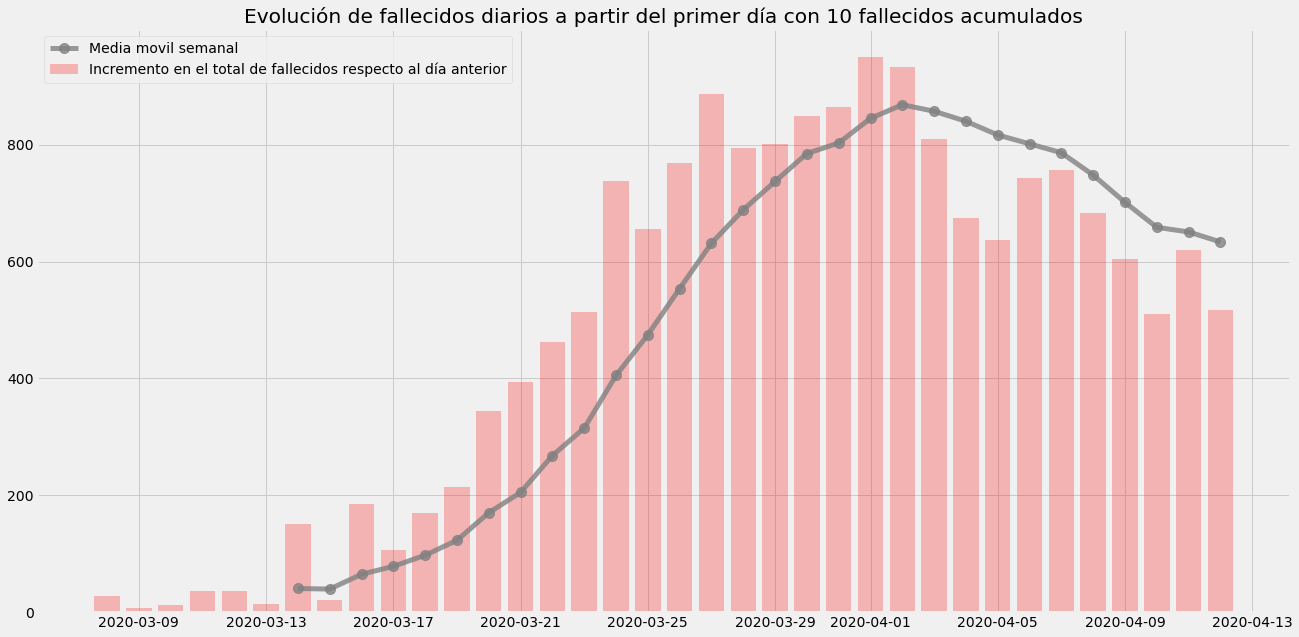

In [675]:
# Let's build our plot
# Set up plot 
fig, ax1 = plt.subplots(figsize=(20,10))
ax2 = ax1 # set up the 2nd axis

#Next lines plot the line of the plot
ax1.plot(data_sem['Diferencia fallecidos dia anterior'],alpha=1.8,color='grey',
         label='Media movil semanal',marker='o', markersize=10,linewidth=5)

#Next lines plot the bar chat part of the plot
ax2.bar(data_es.index, data_es["Diferencia fallecidos dia anterior"],width=0.8, alpha=0.25, color='red',
       label='Incremento en el total de fallecidos respecto al día anterior')

ax1.grid(b=True) #Turn on grid

#set up the title and legend
ax1.set_title('Evolución de fallecidos diarios a partir del primer día con 10 fallecidos acumulados')
ax1.legend()
plt.savefig(r'C:\Users\guillermo.arguello\Documents\GitHub\covid19_spain\resources\imagenes\fallecidos.png');



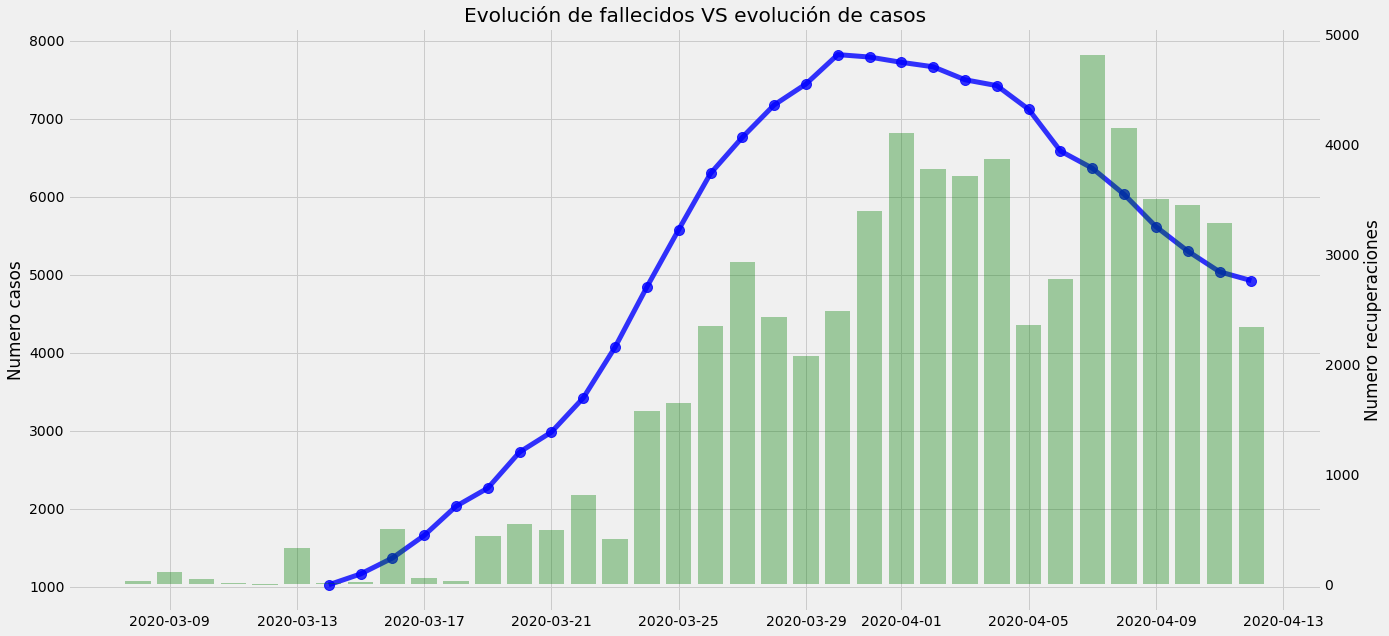

In [676]:
# Let's build our plot
# Set up plot 

fig, ax1 = plt.subplots(figsize=(20,10))
ax2 = ax1.twinx()  # set up the 2nd axis

#Next lines plot the line of the plot

ax1.plot(data_sem['Diferencia casos dia anterior'],alpha=0.8,color='blue',
         label='Incremento en el total de casos respecto al día anterior',marker='o', markersize=10,linewidth=5)

#Next lines plot the bar chat part of the plot
ax2.bar(data_sem.index, data_es["Diferencia recuperados dia anterior"],width=0.8, alpha=0.35, color='green',
       label='Incremento en el total de recuperados respecto al día anterior')


ax2.grid(b=False) # turn off grid #2

ax1.set_title('Evolución de fallecidos VS evolución de casos')
ax1.set_ylabel('Numero casos')
ax2.set_ylabel('Numero recuperaciones');



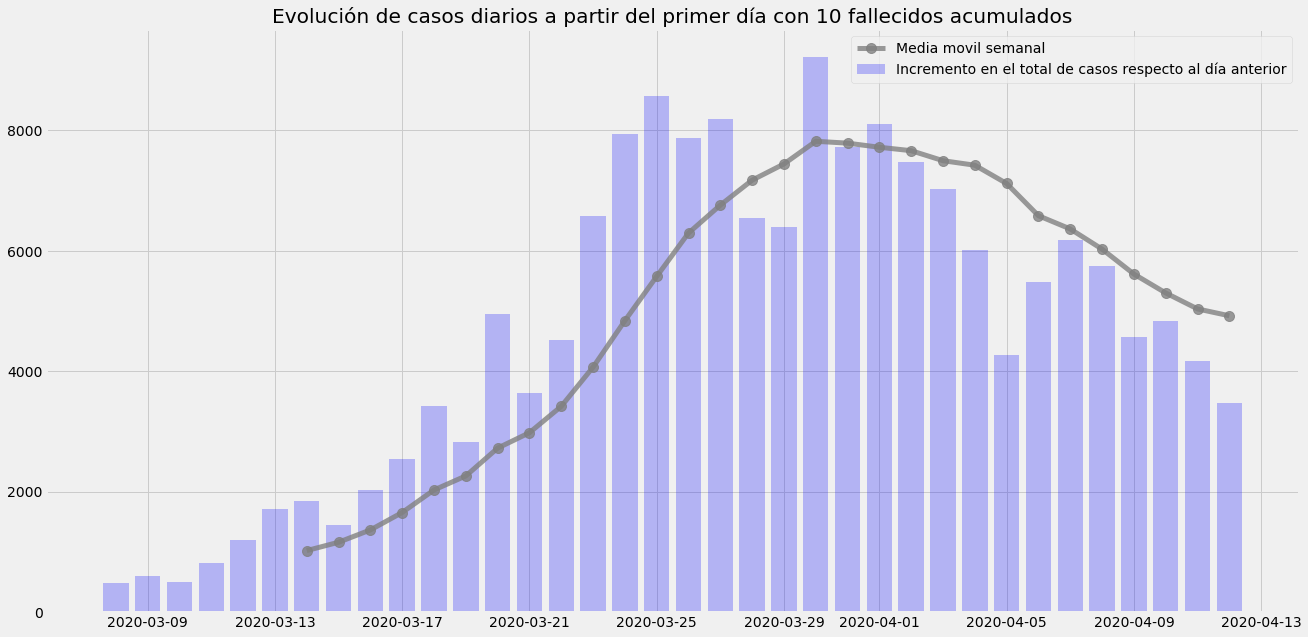

In [677]:
# Let's build our plot
# Set up plot 
fig, ax1 = plt.subplots(figsize=(20,10))
ax2 = ax1 # set up the 2nd axis

#Next lines plot the line of the plot
ax1.plot(data_sem['Diferencia casos dia anterior'],alpha=1.8,color='grey',
         label='Media movil semanal',marker='o', markersize=10,linewidth=5)

#Next lines plot the bar chat part of the plot
ax2.bar(data_es.index, data_es["Diferencia casos dia anterior"],width=0.8, alpha=0.25, color='blue',
       label='Incremento en el total de casos respecto al día anterior')

ax1.grid(b=True) #Turn on grid

#set up the title and legend
ax1.set_title('Evolución de casos diarios a partir del primer día con 10 fallecidos acumulados')
ax1.legend()
plt.savefig(r'C:\Users\guillermo.arguello\Documents\GitHub\covid19_spain\resources\imagenes\casos.png');




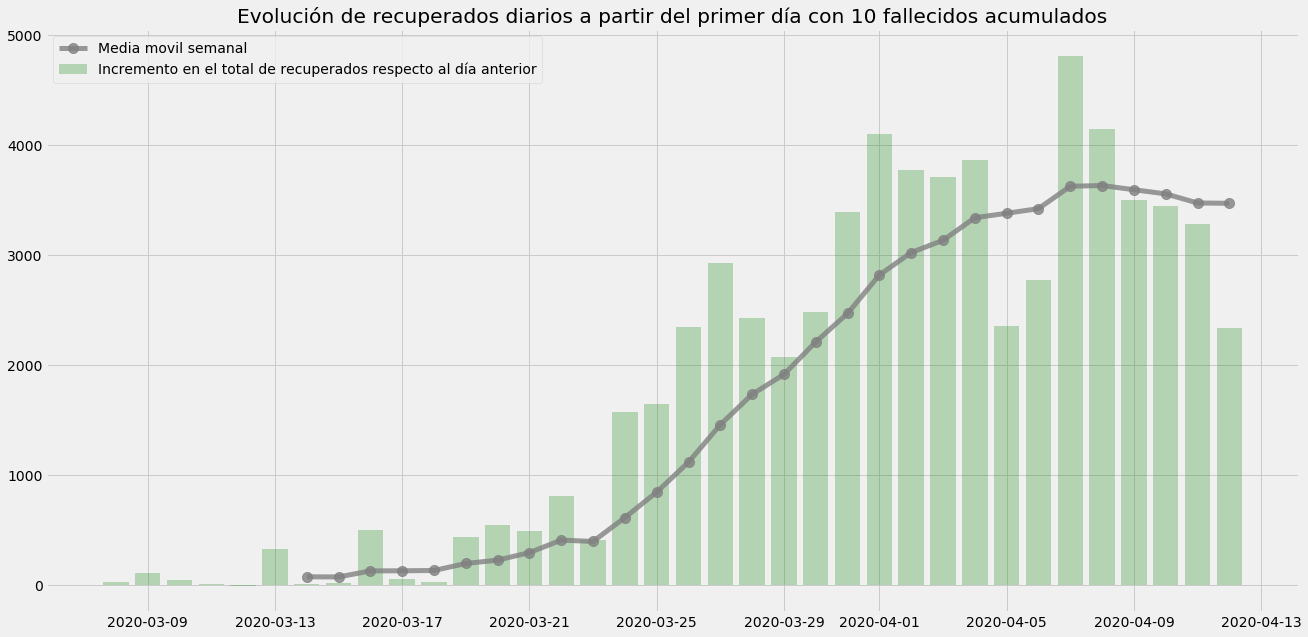

In [678]:
# Let's build our plot
# Set up plot 
fig, ax1 = plt.subplots(figsize=(20,10))
ax2 = ax1 # set up the 2nd axis

#Next lines plot the line of the plot
ax1.plot(data_sem['Diferencia recuperados dia anterior'],alpha=1.8,color='grey',
         label='Media movil semanal',marker='o', markersize=10,linewidth=5)

#Next lines plot the bar chat part of the plot
ax2.bar(data_es.index, data_es["Diferencia recuperados dia anterior"],width=0.8, alpha=0.25, color='green',
       label='Incremento en el total de recuperados respecto al día anterior')

ax1.grid(b=True) #Turn on grid

#set up the title and legend
ax1.set_title('Evolución de recuperados diarios a partir del primer día con 10 fallecidos acumulados')
ax1.legend()
plt.savefig(r'C:\Users\guillermo.arguello\Documents\GitHub\covid19_spain\resources\imagenes\recuperados.png');


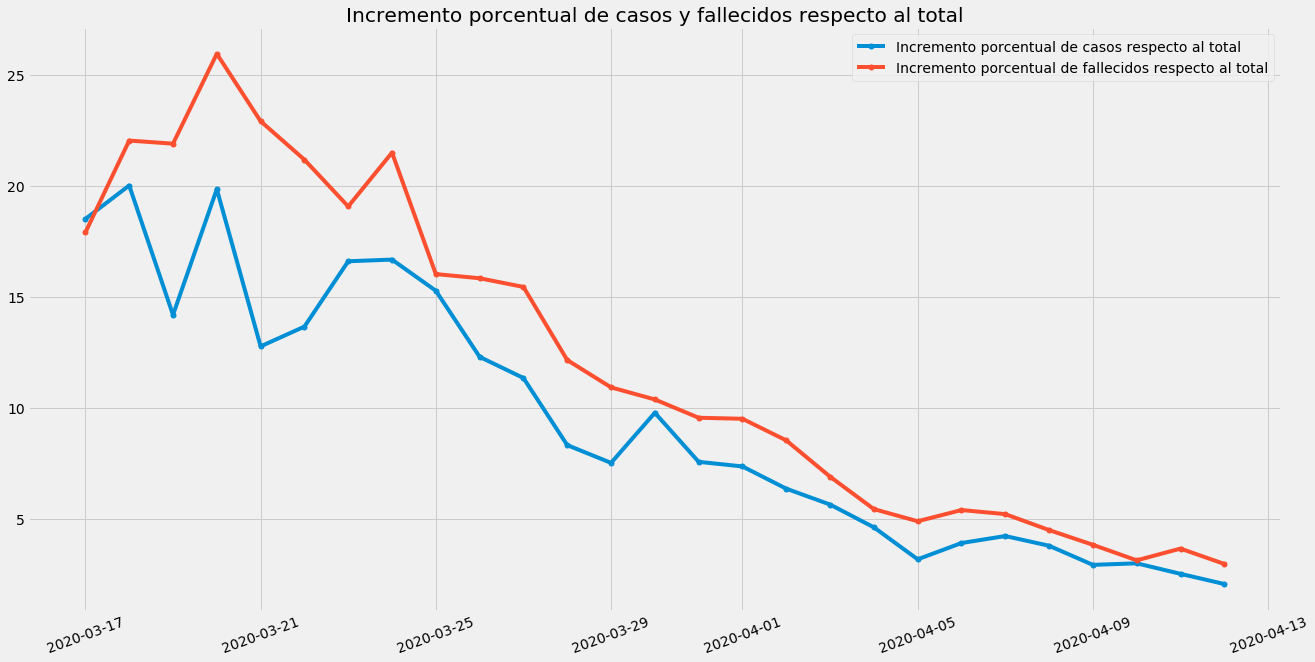

In [679]:
start, end = '2020-03-17 00:00:00', data_es.index.max()
# Plot daily and weekly resampled time series together
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(data_es.loc[start:end, 'Incremento porcentual de casos respecto al total'],
marker='o', markersize=5, linestyle='-', label='Incremento porcentual de casos respecto al total')
ax.plot(data_es.loc[start:end, 'Incremento porcentual de fallecidos respecto al total'],
marker='o', markersize=5, linestyle='-', label='Incremento porcentual de fallecidos respecto al total')
plt.xticks(rotation=20)
plt.title("Incremento porcentual de casos y fallecidos respecto al total")
ax.legend();

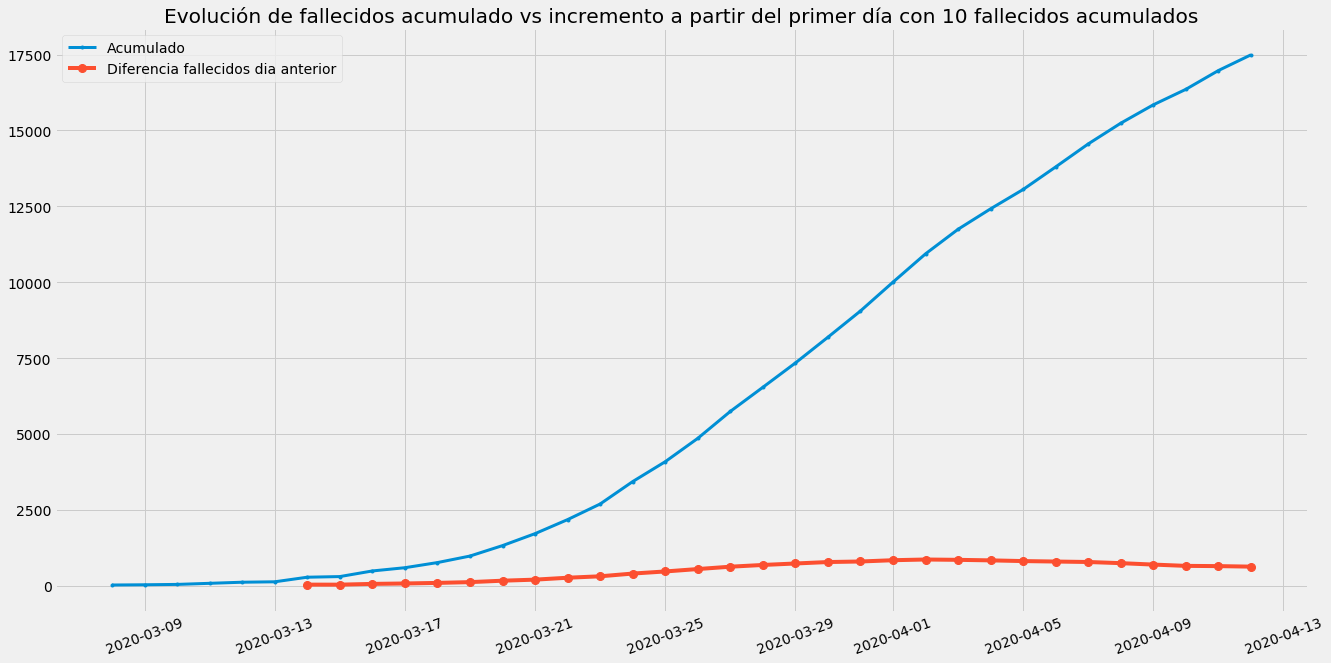

In [680]:
start, end = data_es.index.min(), data_es.index.max()
# Plot daily and weekly resampled time series together
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(data_es.loc[start:end, 'Fallecidos'],
marker='.', linestyle='-', linewidth=3, label='Acumulado')
ax.plot(data_sem.loc[start:end, 'Diferencia fallecidos dia anterior'],
marker='o', markersize=8, linestyle='-', label='Diferencia fallecidos dia anterior')
plt.xticks(rotation=20)
plt.title("Evolución de fallecidos acumulado vs incremento a partir del primer día con 10 fallecidos acumulados")
ax.legend();

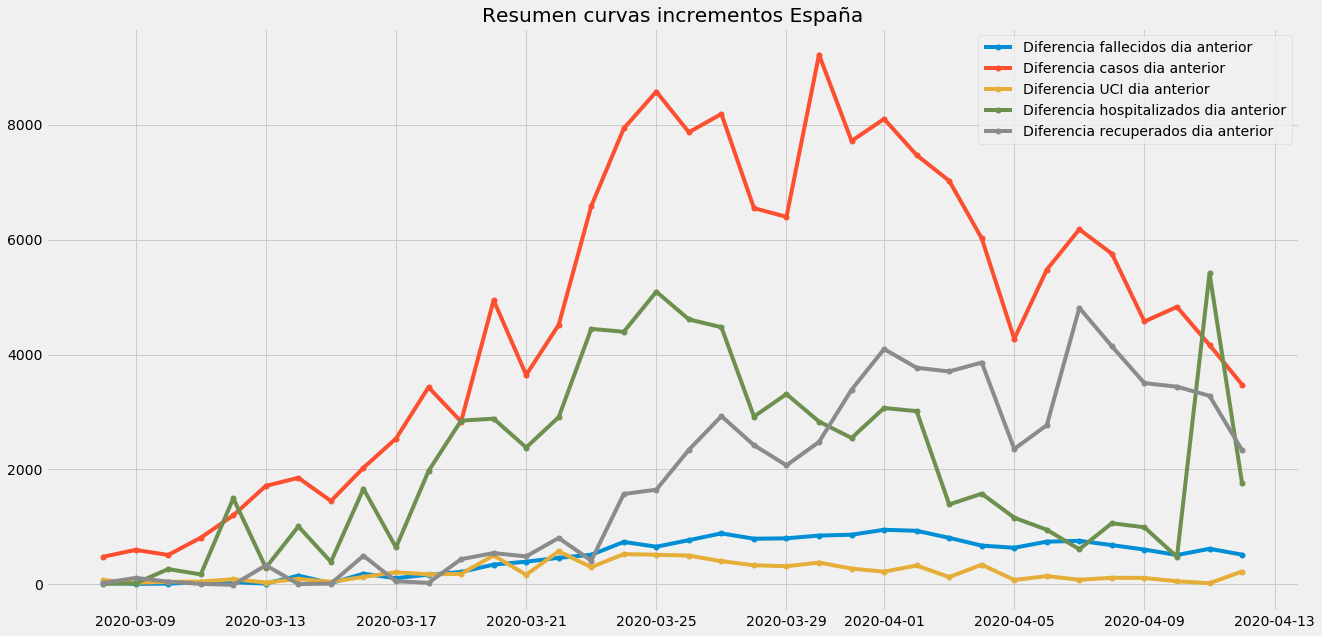

In [681]:
start, end = data_es.index.min(), data_es.index.max()
# Plot daily and weekly resampled time series together
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(data_es.loc[start:end, 'Diferencia fallecidos dia anterior'],
marker='o', markersize=5, linestyle='-', label='Diferencia fallecidos dia anterior')
ax.plot(data_es.loc[start:end, 'Diferencia casos dia anterior'],
marker='o', markersize=5, linestyle='-', label='Diferencia casos dia anterior')
ax.plot(data_es.loc[start:end, 'Diferencia UCI dia anterior'],
marker='o', markersize=5, linestyle='-', label='Diferencia UCI dia anterior')
ax.plot(data_es.loc[start:end, 'Diferencia hospitalizados dia anterior'],
marker='o', markersize=5, linestyle='-', label='Diferencia hospitalizados dia anterior')
ax.plot(data_es.loc[start:end, 'Diferencia recuperados dia anterior'],
marker='o', markersize=5, linestyle='-', label='Diferencia recuperados dia anterior')
plt.title("Resumen curvas incrementos España");
ax.legend();

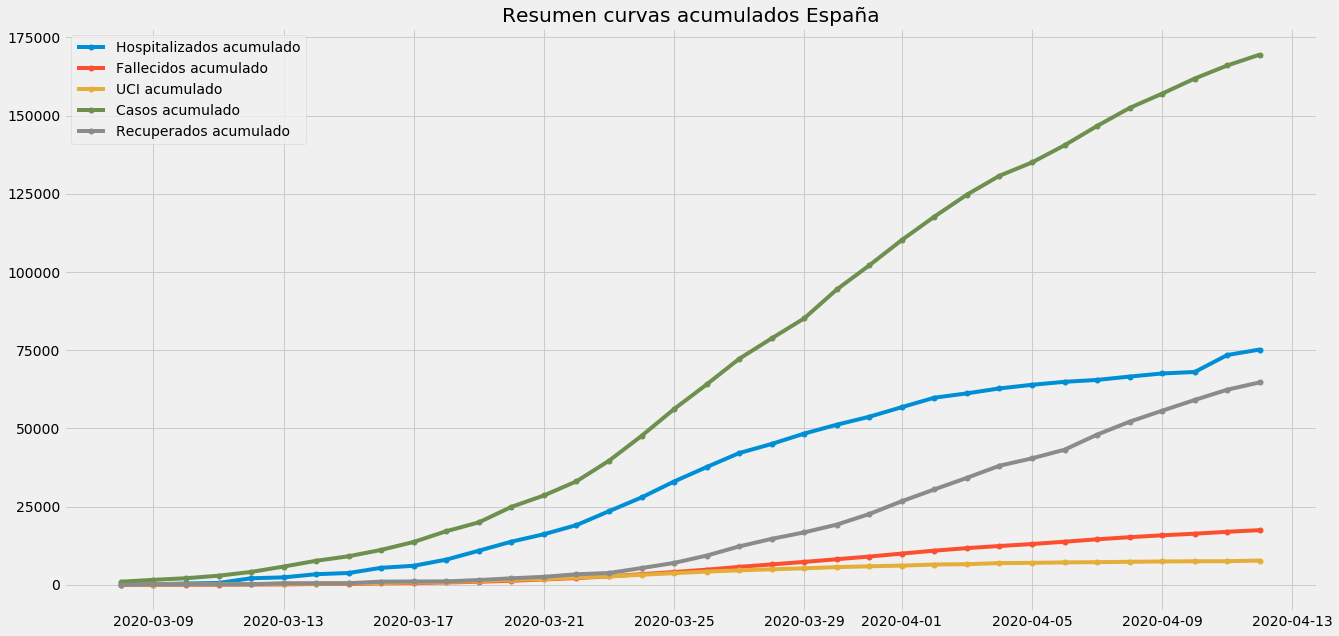

In [682]:
start, end = data_es.index.min(), data_es.index.max()
# Plot daily and weekly resampled time series together
fig, ax = plt.subplots(figsize=(20,10))

ax.plot(data_es.loc[start:end, 'Hospitalizados'],
marker='o', markersize=5, linestyle='-', label='Hospitalizados acumulado')
ax.plot(data_es.loc[start:end, 'Fallecidos'],
marker='o', markersize=5, linestyle='-', label='Fallecidos acumulado')
ax.plot(data_es.loc[start:end, 'UCI'],
marker='o', markersize=5, linestyle='-', label='UCI acumulado')
ax.plot(data_es.loc[start:end, 'Casos'],
marker='o', markersize=5, linestyle='-', label='Casos acumulado')
ax.plot(data_es.loc[start:end, 'Recuperados'],
marker='o', markersize=5, linestyle='-', label='Recuperados acumulado')
plt.title("Resumen curvas acumulados España");
ax.legend();

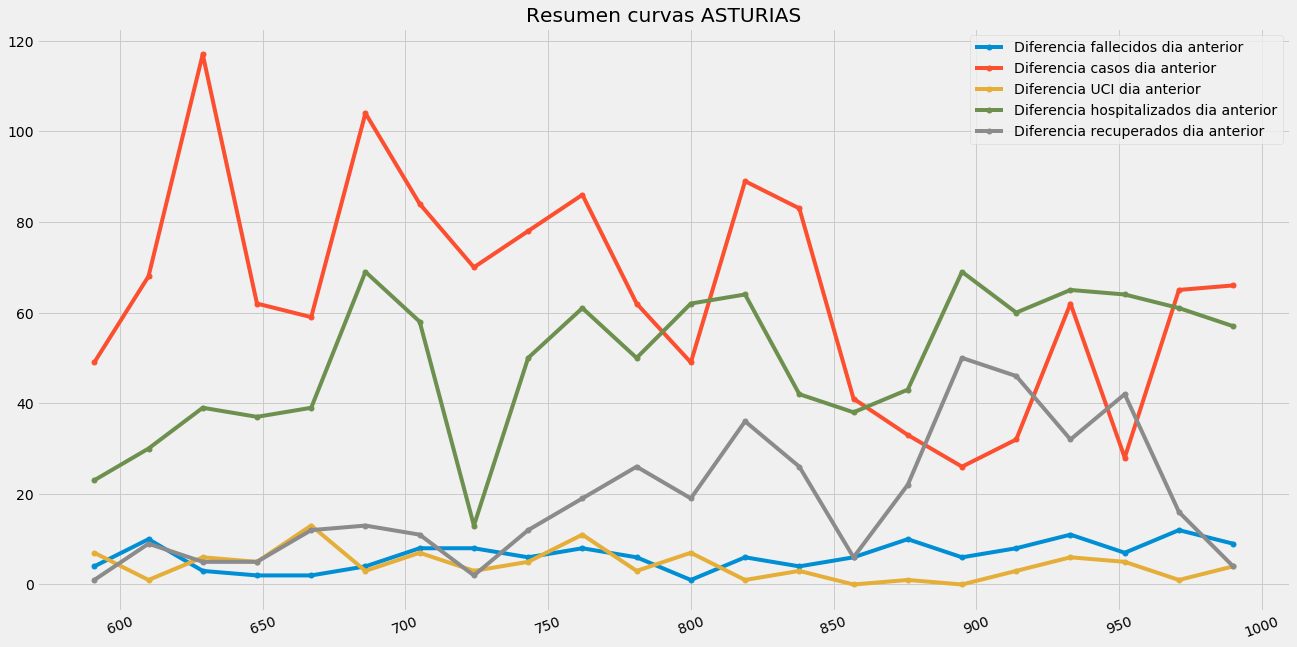

In [683]:
#Introducir código ISO de la comunidad a analizar (ejemplo Asturias) 
data = data[data["Fallecidos"] > 10]

start, end = data[data["CCAA Codigo ISO"] == "AS"].index.min(), data[data["CCAA Codigo ISO"] == "AS"].index.max()
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(data[data["CCAA Codigo ISO"] == "AS"].loc[start:end, 'Diferencia fallecidos dia anterior'],
marker='o', markersize=5, linestyle='-', label='Diferencia fallecidos dia anterior')
ax.plot(data[data["CCAA Codigo ISO"] == "AS"].loc[start:end, 'Diferencia casos dia anterior'],
marker='o', markersize=5, linestyle='-', label='Diferencia casos dia anterior')
ax.plot(data[data["CCAA Codigo ISO"] == "AS"].loc[start:end, 'Diferencia UCI dia anterior'],
marker='o', markersize=5, linestyle='-', label='Diferencia UCI dia anterior')
ax.plot(data[data["CCAA Codigo ISO"] == "AS"].loc[start:end, 'Diferencia hospitalizados dia anterior'],
marker='o', markersize=5, linestyle='-', label='Diferencia hospitalizados dia anterior')
ax.plot(data[data["CCAA Codigo ISO"] == "AS"].loc[start:end, 'Diferencia recuperados dia anterior'],
marker='o', markersize=5, linestyle='-', label='Diferencia recuperados dia anterior')
ax.legend()
plt.xticks(rotation=20)
plt.title("Resumen curvas ASTURIAS");

Casos positivos: 30701
Casos negativos: 44277
Numero de tests totales: 74978


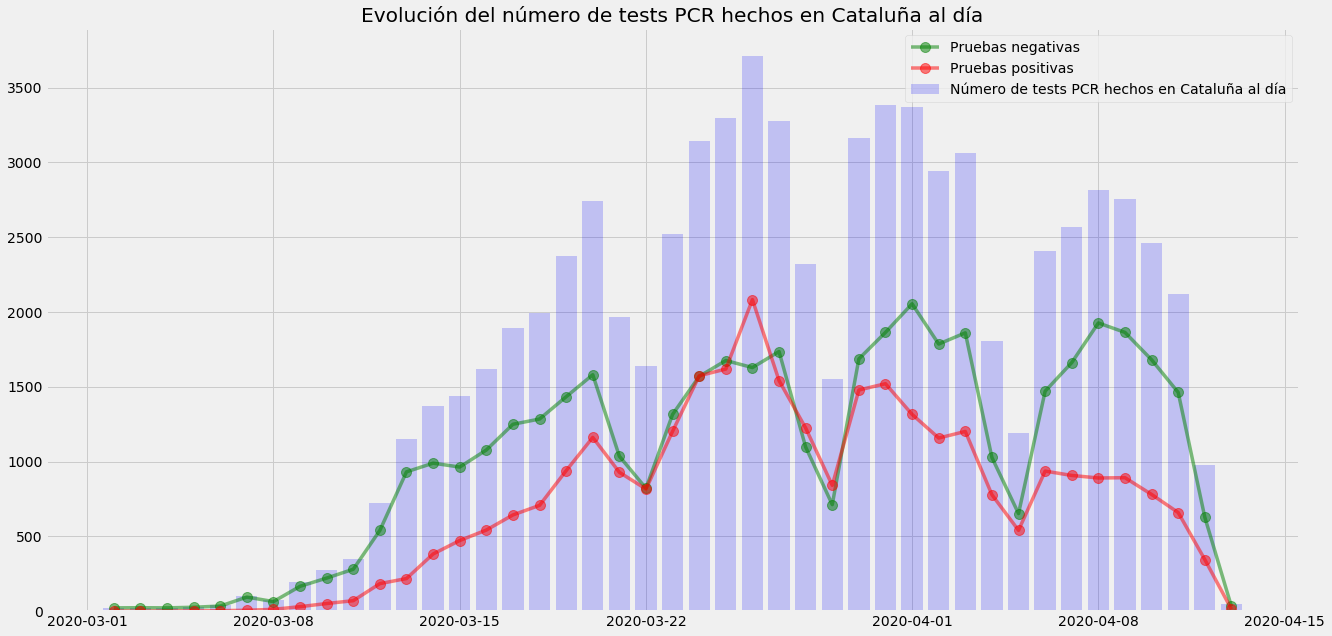

In [684]:
fig, ax1 = plt.subplots(figsize=(20,10))
ax2 = ax1 # set up the 2nd axis

#Next lines plot the line of the plot
ax1.plot(data_cat_gropued_resultado[data_cat_gropued_resultado['ResultatCovidDescripcio'] == "Negatiu"]["NumCasos"]
         ,alpha=0.5,color='green',
         label='Pruebas negativas',marker='o', markersize=10,linewidth=3.5)

ax1.plot(data_cat_gropued_resultado[data_cat_gropued_resultado['ResultatCovidDescripcio'] == "Positiu"]["NumCasos"]
         ,alpha=0.5,color='red',
         label='Pruebas positivas',marker='o', markersize=10,linewidth=3.5)


#Next lines plot the bar chat part of the plot
ax2.bar(data_cat_gropued.index, data_cat_gropued["NumCasos"],width=0.8, alpha=0.2, color='blue',
       label='Número de tests PCR hechos en Cataluña al día')

ax1.grid(b=True) #Turn on grid

print ("Casos positivos:", data_cat_gropued_resultado[data_cat_gropued_resultado['ResultatCovidDescripcio'] == "Positiu"]["NumCasos"].sum())
print ("Casos negativos:", data_cat_gropued_resultado[data_cat_gropued_resultado['ResultatCovidDescripcio'] == "Negatiu"]["NumCasos"].sum())
print ("Numero de tests totales:", data_cat_gropued_resultado["NumCasos"].sum())

#set up the title and legend
ax1.set_title('Evolución del número de tests PCR hechos en Cataluña al día')
ax1.legend()
plt.savefig(r'C:\Users\guillermo.arguello\Documents\GitHub\covid19_spain\resources\imagenes\tests.png');



In [685]:
data_sem_jh = data_sem_jh[data_sem_jh["Fallecidos"] >= 10]
data_sem_jh = data_sem_jh.reset_index()
data_sem_jh = data_sem_jh.set_index('Fecha')
data_sem_jh = data_sem_jh.reset_index()
data_sem_jh["Time_delta"] = 0
data_sem_jh["Time_delta"] = pd.to_timedelta(data_sem_jh["Time_delta"])


In [686]:
data_sem_jh

,Fecha,Country/Region,Casos,Fallecidos,Recuperados,Diferencia casos dia anterior,Diferencia fallecidos dia anterior,Diferencia recuperados dia anterior,Incremento porcentual de casos respecto al total,Incremento porcentual de fallecidos respecto al total,Time_delta
0,2020-04-09,Afghanistan,378.142857,10.571429,18.857143,30.142857,1.285714,3.142857,7.761612,11.249227,0 days
1,2020-04-10,Afghanistan,412.428571,11.857143,22.000000,34.285714,1.285714,3.142857,8.369434,11.249227,0 days
2,2020-04-11,Afghanistan,449.000000,13.428571,25.142857,36.571429,1.571429,3.142857,8.384585,11.589363,0 days
3,2020-04-12,Afghanistan,485.857143,15.000000,27.571429,36.857143,1.571429,2.428571,7.561739,11.589363,0 days
4,2020-04-01,Albania,213.428571,10.714286,39.285714,16.142857,1.428571,7.142857,7.791941,13.917749,0 days
...,...,...,...,...,...,...,...,...,...,...,...
1369,2020-04-08,United Kingdom,47639.571429,4923.857143,257.285714,4515.571429,679.142857,23.714286,9.771092,14.513688,0 days
1370,2020-04-09,United Kingdom,52168.000000,5647.714286,281.142857,4528.428571,723.857143,23.857143,8.923969,13.312018,0 days
1371,2020-04-10,United Kingdom,57298.857143,6413.857143,335.428571,5130.857143,766.142857,54.285714,8.928695,12.163699,0 days
1372,2020-04-11,United Kingdom,62641.285714,7209.857143,393.571429,5342.428571,796.000000,58.142857,8.597105,11.144869,0 days


In [687]:
for geo in data_sem_jh["Country/Region"].unique():
    data_sem_out = data_sem_jh[data_sem_jh["Country/Region"] == geo]
    data_sem_out["Time_delta"] = data_sem_out[data_sem_out["Country/Region"] == geo]["Fecha"] - data_sem_out[data_sem_out["Country/Region"] == geo]["Fecha"].min()
    data_sem_jh[data_sem_jh["Country/Region"] == geo] = data_sem_out[data_sem_out["Country/Region"] == geo]

In [688]:
data_sem_jh["Time_delta"] = data_sem_jh["Time_delta"].astype('timedelta64[D]')
data_sem_jh = data_sem_jh.set_index('Time_delta')


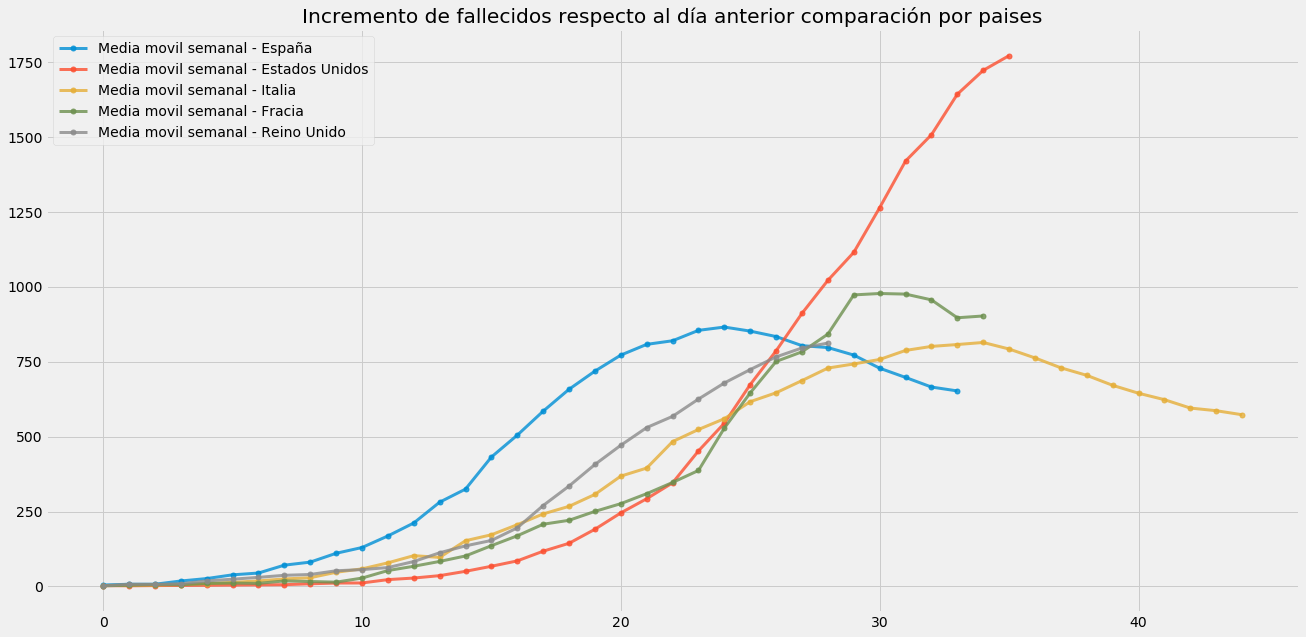

In [689]:
# Plot daily and weekly resampled time series together
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(data_sem_jh[(data_sem_jh["Country/Region"] == "Spain") & 
                    (data_sem_jh["Fallecidos"] > 10)]['Diferencia fallecidos dia anterior'],
marker='o', alpha=0.8,linewidth=3, markersize=5, linestyle='-', label='Media movil semanal - España')

ax.plot(data_sem_jh[(data_sem_jh["Country/Region"] == "US") & 
                    (data_sem_jh["Fallecidos"] > 10)]['Diferencia fallecidos dia anterior'],
marker='o', alpha=0.8,linewidth=3,markersize=5, linestyle='-', label='Media movil semanal - Estados Unidos')

ax.plot(data_sem_jh[(data_sem_jh["Country/Region"] == "Italy") & 
                    (data_sem_jh["Fallecidos"] > 10)]['Diferencia fallecidos dia anterior'],
marker='o',alpha=0.8,linewidth=3, markersize=5, linestyle='-', label='Media movil semanal - Italia')

ax.plot(data_sem_jh[(data_sem_jh["Country/Region"] == "France") & 
                    (data_sem_jh["Fallecidos"] > 10)]['Diferencia fallecidos dia anterior'],
marker='o',alpha=0.8 ,linewidth=3,markersize=5, linestyle='-', label='Media movil semanal - Fracia')

ax.plot(data_sem_jh[(data_sem_jh["Country/Region"] == "United Kingdom") 
                    & (data_sem_jh["Fallecidos"] > 10)]['Diferencia fallecidos dia anterior'],
marker='o',alpha=0.8,linewidth=3, markersize=5, linestyle='-', label='Media movil semanal - Reino Unido')

plt.title("Incremento de fallecidos respecto al día anterior comparación por paises")
ax.legend()
plt.savefig(r'C:\Users\guillermo.arguello\Documents\GitHub\covid19_spain\resources\imagenes\paises.png');

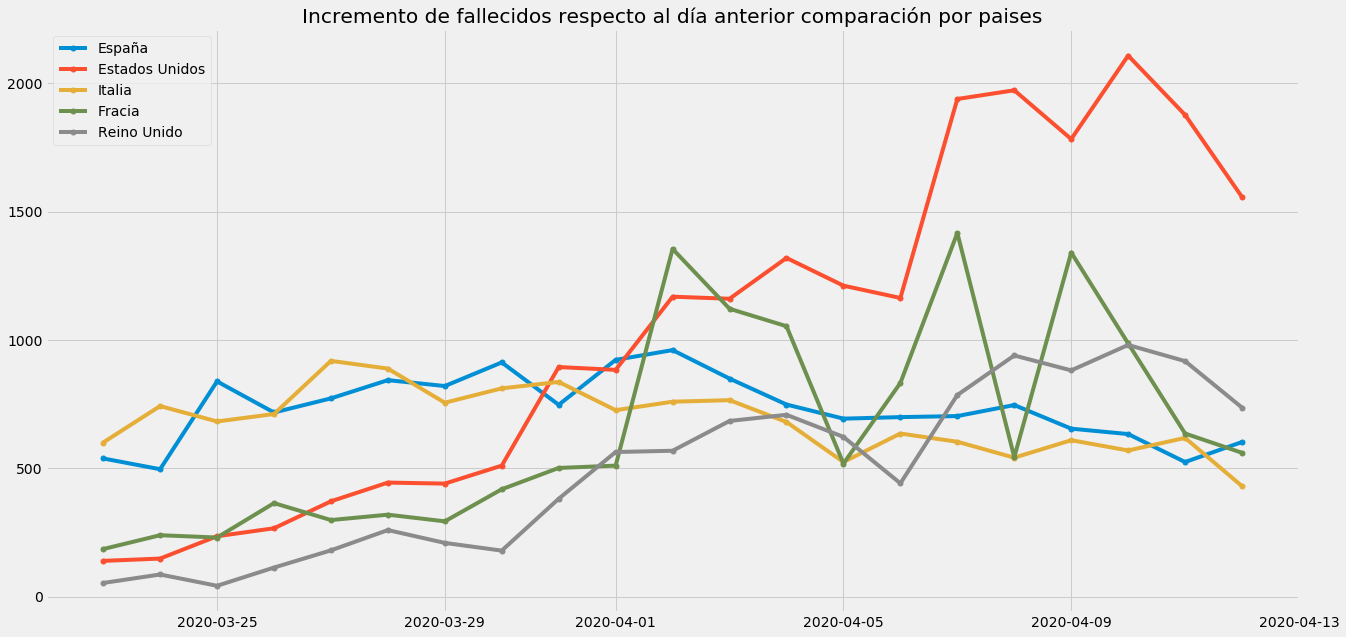

In [690]:
start, end = '2020-03-23 00:00:00', data_jh[(data_jh["Country/Region"] == "Spain") & (data_jh["Fallecidos"] > 10)].index.max()
# Plot daily and weekly resampled time series together
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(data_jh[(data_jh["Country/Region"] == "Spain") & (data_jh["Fallecidos"] > 10)].loc[start:end, 'Diferencia fallecidos dia anterior'],
marker='o', markersize=5, linestyle='-', label='España')
ax.plot(data_jh[(data_jh["Country/Region"] == "US") & (data_jh["Fallecidos"] > 10)].loc[start:end, 'Diferencia fallecidos dia anterior'],
marker='o', markersize=5, linestyle='-', label='Estados Unidos')
ax.plot(data_jh[(data_jh["Country/Region"] == "Italy") & (data_jh["Fallecidos"] > 10)].loc[start:end, 'Diferencia fallecidos dia anterior'],
marker='o', markersize=5, linestyle='-', label='Italia')
ax.plot(data_jh[(data_jh["Country/Region"] == "France") & (data_jh["Fallecidos"] > 10)].loc[start:end, 'Diferencia fallecidos dia anterior'],
marker='o', markersize=5, linestyle='-', label='Fracia')
ax.plot(data_jh[(data_jh["Country/Region"] == "United Kingdom") & (data_jh["Fallecidos"] > 10)].loc[start:end, 'Diferencia fallecidos dia anterior'],
marker='o', markersize=5, linestyle='-', label='Reino Unido')
plt.title("Incremento de fallecidos respecto al día anterior comparación por paises");
ax.legend();

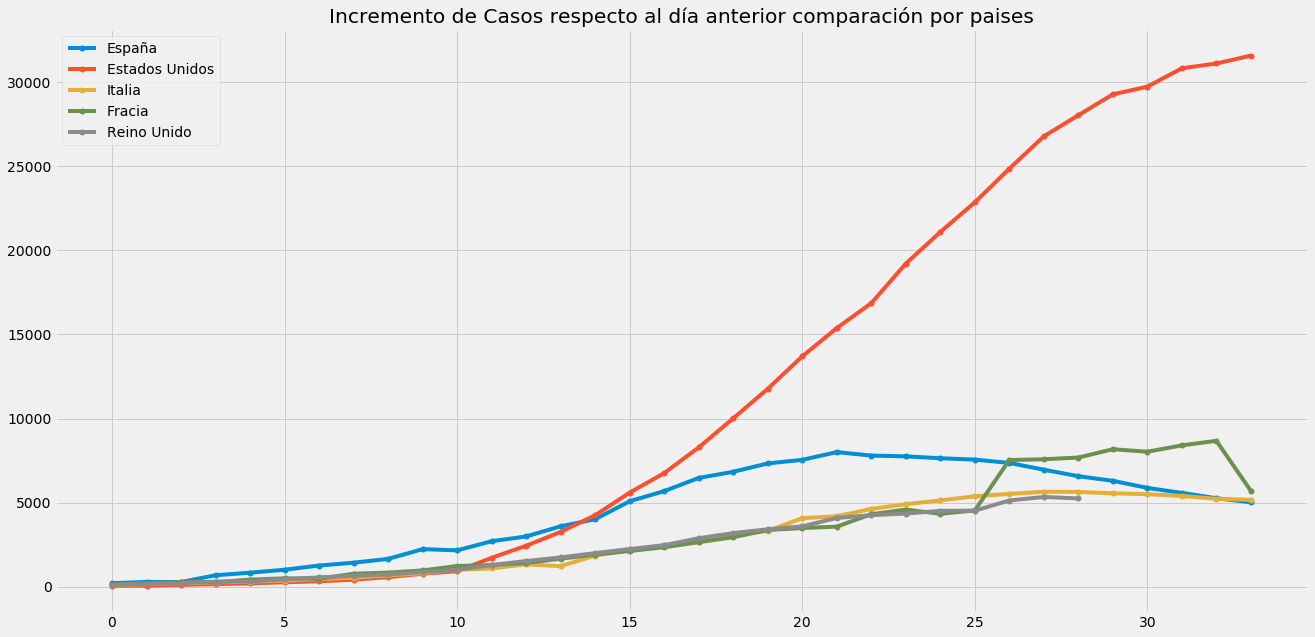

In [691]:
start, end = data_sem_jh[(data_sem_jh["Country/Region"] == "Spain") & (data_sem_jh["Fallecidos"] > 10)].index.min(), data_sem_jh[(data_sem_jh["Country/Region"] == "Spain") & (data_sem_jh["Fallecidos"] > 10)].index.max()
# Plot daily and weekly resampled time series together
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(data_sem_jh[(data_sem_jh["Country/Region"] == "Spain") & (data_sem_jh["Casos"] > 10)].loc[start:end, 'Diferencia casos dia anterior'],
marker='o', markersize=5, linestyle='-', label='España')
ax.plot(data_sem_jh[(data_sem_jh["Country/Region"] == "US") & (data_sem_jh["Casos"] > 10)].loc[start:end, 'Diferencia casos dia anterior'],
marker='o', markersize=5, linestyle='-', label='Estados Unidos')
ax.plot(data_sem_jh[(data_sem_jh["Country/Region"] == "Italy") & (data_sem_jh["Casos"] > 10)].loc[start:end, 'Diferencia casos dia anterior'],
marker='o', markersize=5, linestyle='-', label='Italia')
ax.plot(data_sem_jh[(data_sem_jh["Country/Region"] == "France") & (data_sem_jh["Casos"] > 10)].loc[start:end, 'Diferencia casos dia anterior'],
marker='o', markersize=5, linestyle='-', label='Fracia')
ax.plot(data_sem_jh[(data_sem_jh["Country/Region"] == "United Kingdom") & (data_sem_jh["Casos"] > 10)].loc[start:end, 'Diferencia casos dia anterior'],
marker='o', markersize=5, linestyle='-', label='Reino Unido')
plt.title("Incremento de Casos respecto al día anterior comparación por paises");
ax.legend();

In [692]:
data_jh[["Country/Region","Diferencia casos dia anterior"]].sort_values("Diferencia casos dia anterior",
                                                                            ascending=False).head(10)

,Country/Region,Diferencia casos dia anterior
Fecha,,
2020-04-10,US,35098.0
2020-04-04,US,33267.0
2020-04-08,US,32829.0
2020-04-09,US,32385.0
2020-04-03,US,31824.0
2020-04-02,US,30390.0
2020-04-11,US,29861.0
2020-04-06,US,29595.0
2020-04-07,US,29556.0


In [693]:
data_jh[["Country/Region","Diferencia fallecidos dia anterior"]].sort_values("Diferencia fallecidos dia anterior",
                                                                            ascending=False).head(10)

,Country/Region,Diferencia fallecidos dia anterior
Fecha,,
2020-04-10,US,2108.0
2020-04-08,US,1973.0
2020-04-07,US,1939.0
2020-04-11,US,1877.0
2020-04-09,US,1783.0
2020-04-12,US,1557.0
2020-04-07,France,1417.0
2020-04-02,France,1355.0
2020-04-09,France,1341.0


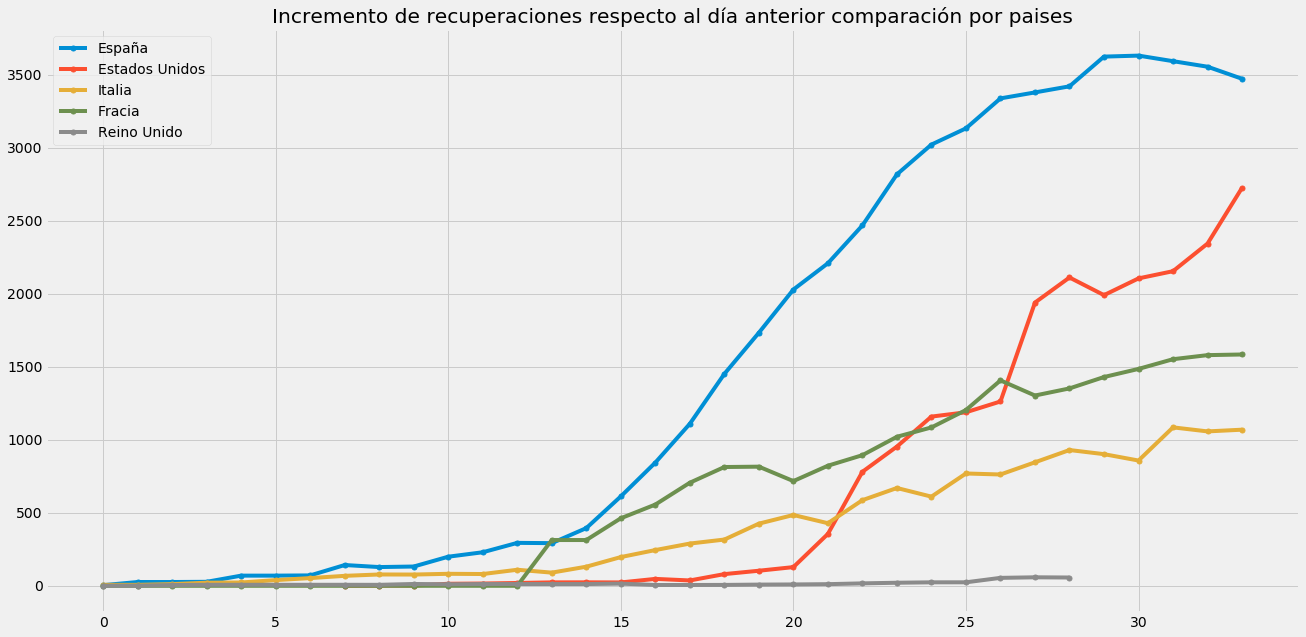

In [694]:
start, end = data_sem_jh[(data_sem_jh["Country/Region"] == "Spain") & (data_sem_jh["Recuperados"] > 10)].index.min(), data_sem_jh[(data_sem_jh["Country/Region"] == "Spain") & (data_sem_jh["Recuperados"] > 10)].index.max()
# Plot daily and weekly resampled time series together
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(data_sem_jh[(data_sem_jh["Country/Region"] == "Spain") & (data_sem_jh["Recuperados"] > 10)].loc[start:end, 'Diferencia recuperados dia anterior'],
marker='o', markersize=5, linestyle='-', label='España')
ax.plot(data_sem_jh[(data_sem_jh["Country/Region"] == "US") & (data_sem_jh["Recuperados"] > 10)].loc[start:end, 'Diferencia recuperados dia anterior'],
marker='o', markersize=5, linestyle='-', label='Estados Unidos')
ax.plot(data_sem_jh[(data_sem_jh["Country/Region"] == "Italy") & (data_sem_jh["Recuperados"] > 10)].loc[start:end, 'Diferencia recuperados dia anterior'],
marker='o', markersize=5, linestyle='-', label='Italia')
ax.plot(data_sem_jh[(data_sem_jh["Country/Region"] == "France") & (data_sem_jh["Recuperados"] > 10)].loc[start:end, 'Diferencia recuperados dia anterior'],
marker='o', markersize=5, linestyle='-', label='Fracia')
ax.plot(data_sem_jh[(data_sem_jh["Country/Region"] == "United Kingdom") & (data_sem_jh["Recuperados"] > 10)].loc[start:end, 'Diferencia recuperados dia anterior'],
marker='o', markersize=5, linestyle='-', label='Reino Unido')
plt.title("Incremento de recuperaciones respecto al día anterior comparación por paises");
ax.legend();

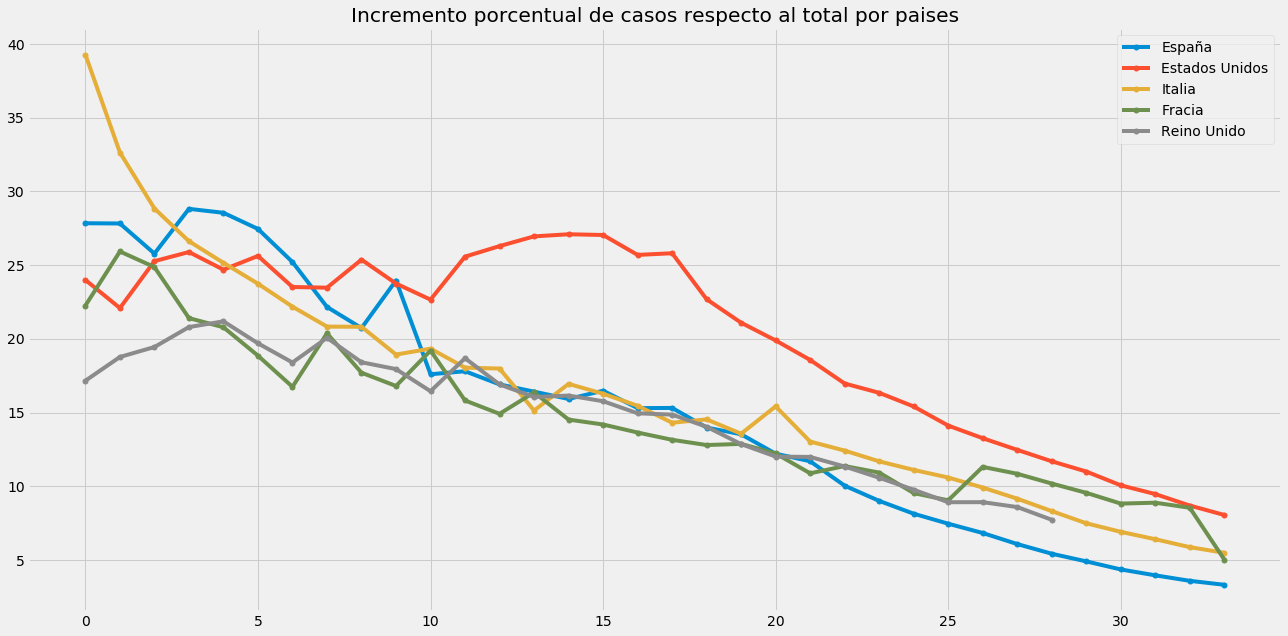

In [695]:
start, end = data_sem_jh[(data_sem_jh["Country/Region"] == "Spain") & (data_sem_jh["Casos"] > 10)].index.min(), data_sem_jh[(data_sem_jh["Country/Region"] == "Spain") & (data_sem_jh["Recuperados"] > 10)].index.max()
# Plot daily and weekly resampled time series together
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(data_sem_jh[(data_sem_jh["Country/Region"] == "Spain") & (data_sem_jh["Casos"] > 10)].loc[start:end, 'Incremento porcentual de casos respecto al total'],
marker='o', markersize=5, linestyle='-', label='España')
ax.plot(data_sem_jh[(data_sem_jh["Country/Region"] == "US") & (data_sem_jh["Casos"] > 10)].loc[start:end, 'Incremento porcentual de casos respecto al total'],
marker='o', markersize=5, linestyle='-', label='Estados Unidos')
ax.plot(data_sem_jh[(data_sem_jh["Country/Region"] == "Italy") & (data_sem_jh["Casos"] > 10)].loc[start:end, 'Incremento porcentual de casos respecto al total'],
marker='o', markersize=5, linestyle='-', label='Italia')
ax.plot(data_sem_jh[(data_sem_jh["Country/Region"] == "France") & (data_sem_jh["Casos"] > 10)].loc[start:end, 'Incremento porcentual de casos respecto al total'],
marker='o', markersize=5, linestyle='-', label='Fracia')
ax.plot(data_sem_jh[(data_sem_jh["Country/Region"] == "United Kingdom") & (data_sem_jh["Casos"] > 10)].loc[start:end, 'Incremento porcentual de casos respecto al total'],
marker='o', markersize=5, linestyle='-', label='Reino Unido')
plt.title("Incremento porcentual de casos respecto al total por paises");
ax.legend();

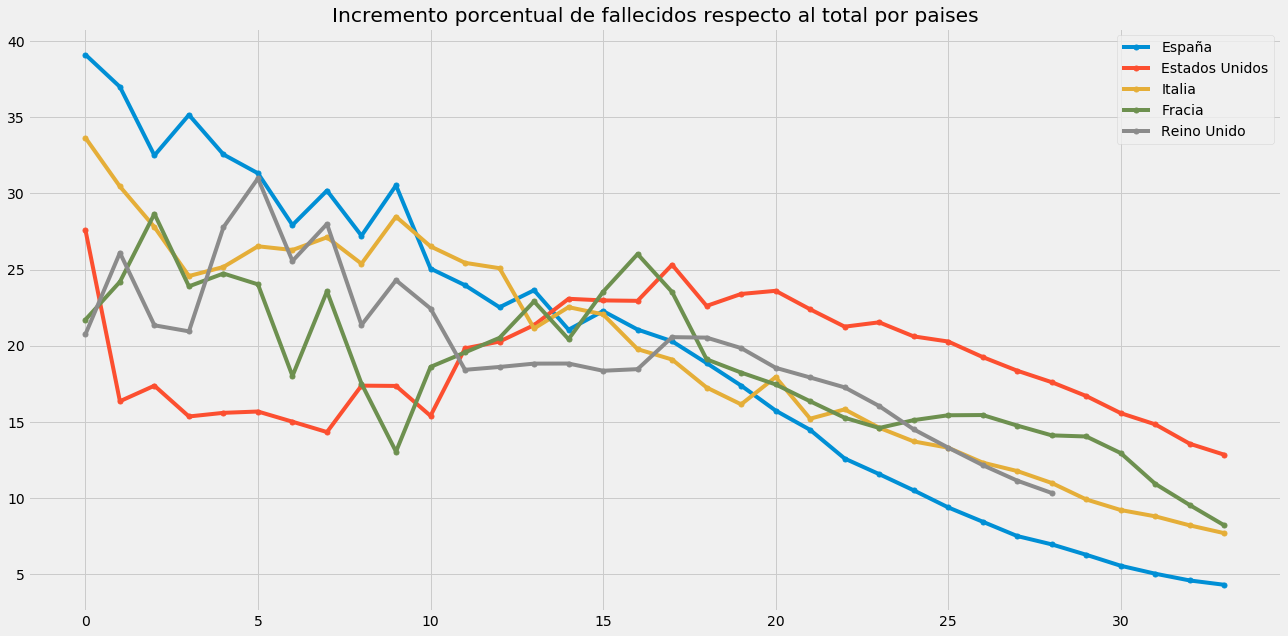

In [696]:
start, end = data_sem_jh[(data_sem_jh["Country/Region"] == "Spain") & (data_sem_jh["Fallecidos"] > 10)].index.min(), data_sem_jh[(data_sem_jh["Country/Region"] == "Spain") & (data_sem_jh["Recuperados"] > 10)].index.max()
# Plot daily and weekly resampled time series together
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(data_sem_jh[(data_sem_jh["Country/Region"] == "Spain") & (data_sem_jh["Fallecidos"] > 10)].loc[start:end, 'Incremento porcentual de fallecidos respecto al total'],
marker='o', markersize=5, linestyle='-', label='España')
ax.plot(data_sem_jh[(data_sem_jh["Country/Region"] == "US") & (data_sem_jh["Fallecidos"] > 10)].loc[start:end, 'Incremento porcentual de fallecidos respecto al total'],
marker='o', markersize=5, linestyle='-', label='Estados Unidos')
ax.plot(data_sem_jh[(data_sem_jh["Country/Region"] == "Italy") & (data_sem_jh["Fallecidos"] > 10)].loc[start:end, 'Incremento porcentual de fallecidos respecto al total'],
marker='o', markersize=5, linestyle='-', label='Italia')
ax.plot(data_sem_jh[(data_sem_jh["Country/Region"] == "France") & (data_sem_jh["Fallecidos"] > 10)].loc[start:end, 'Incremento porcentual de fallecidos respecto al total'],
marker='o', markersize=5, linestyle='-', label='Fracia')
ax.plot(data_sem_jh[(data_sem_jh["Country/Region"] == "United Kingdom") & (data_sem_jh["Fallecidos"] > 10)].loc[start:end, 'Incremento porcentual de fallecidos respecto al total'],
marker='o', markersize=5, linestyle='-', label='Reino Unido')
plt.title("Incremento porcentual de fallecidos respecto al total por paises");
ax.legend();

In [697]:
from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA


In [698]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
data_sem.index.freq="D"
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(np.log(data_sem["Diferencia fallecidos dia anterior"]),order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue
                        


ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:194.8251508156997
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:143.08837198861323
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:146.11670335425802
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:27.41753639342433
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:156.88846276568222
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:136.4928369144952
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:22.151454743736306
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:18.871030838896097
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:159.47772855905885
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:112.28269149964274
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:111.70490664117186
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:8.176876125683005
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:133.84395782910252
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:114.28260276513858
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:17.807703521101807
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:10.192102326689582
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:-4.188628918995416
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:-31.70398693377

In [699]:
mod2 = sm.tsa.statespace.SARIMAX(np.log(data_sem["Diferencia fallecidos dia anterior"]),
                                order=(0, 1, 0),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results2 = mod2.fit()
print(results2.summary())

                                       SARIMAX Results                                        
Dep. Variable:     Diferencia fallecidos dia anterior   No. Observations:                   36
Model:               SARIMAX(0, 1, 0)x(0, 1, [1], 12)   Log Likelihood                   3.274
Date:                                Mon, 13 Apr 2020   AIC                             -2.547
Time:                                        14:59:27   BIC                             -1.942
Sample:                                    03-08-2020   HQIC                            -3.211
                                         - 04-12-2020                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L12       0.4686      1.146      0.409      0.683      -1.778       2.715
sig

In [700]:
data_sem.index.max()

Timestamp('2020-04-12 00:00:00')

2020-04-13    600.305713
2020-04-14    580.441930
2020-04-15    514.372182
2020-04-16    470.075726
2020-04-17    410.360768
2020-04-18    376.285953
2020-04-19    345.305038
2020-04-20    294.756193
2020-04-21    276.948917
2020-04-22    250.401990
Freq: D, dtype: float64


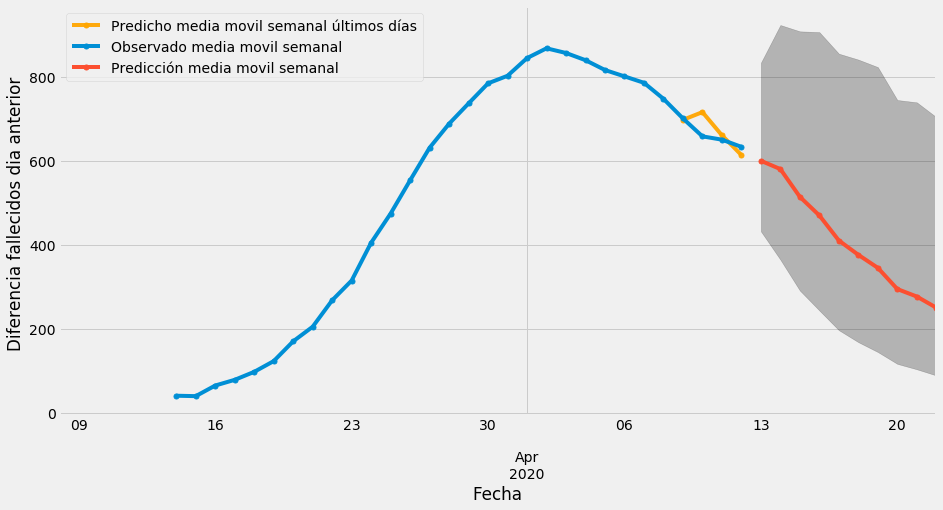

In [701]:
pred_uc_prev = results2.get_prediction(start=pd.to_datetime('2020-04-09 00:00:00'))

pred_uc_prev = math.e**pred_uc_prev.predicted_mean

ax = pred_uc_prev.plot( alpha=.95, figsize=(14, 7),color= "orange",
                       label='Predicho media movil semanal últimos días',marker='o', markersize=5)

pred_uc = results2.get_forecast(steps=10)

pred_ci = pred_uc.conf_int()
pred_ci = math.e**pred_ci
pred_uc = math.e**pred_uc.predicted_mean
ax = data_sem["Diferencia fallecidos dia anterior"].plot(label='Observado media movil semanal', figsize=(14, 7),marker='o', markersize=5)
pred_uc.plot(ax=ax, label='Predicción media movil semanal',marker='o', markersize=5)
print(pred_uc)
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Fecha')
ax.set_ylabel('Diferencia fallecidos dia anterior ')
plt.legend()
plt.savefig(r'C:\Users\guillermo.arguello\Documents\GitHub\covid19_spain\resources\imagenes\predicción.png')
plt.show()


In [702]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(np.log(data_sem["Diferencia casos dia anterior"]),order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue
                        


ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:214.9445669621262
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:156.83512443713553
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:131.8071075334625
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:17.837167693697854
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:143.06342326714642
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:122.17036038243162
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:18.77704028677758
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:17.48221177375192
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:179.60596896501502
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:125.3318358166571
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:97.7611827026177
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:0.010243864513828527
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:178.36715535315057
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:155.5191336298524
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:9.14945529212477
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:10.333770769996788
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:-29.565998492235735
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:-46.56704747737052

In [703]:
mod = sm.tsa.statespace.SARIMAX(np.log(data_sem["Diferencia casos dia anterior"]),
                                order=(0, 1, 0),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.0148      0.415     -0.036      0.972      -0.828       0.798
ma.S.L12      -0.0005   8516.373  -5.78e-08      1.000   -1.67e+04    1.67e+04
sigma2         0.0108      0.088      0.122      0.903      -0.162       0.183


2020-04-13    4894.523004
2020-04-14    4865.462848
2020-04-15    4771.332979
2020-04-16    4736.562905
2020-04-17    4557.521294
2020-04-18    4229.007931
2020-04-19    4097.320895
2020-04-20    3889.017801
2020-04-21    3629.435773
2020-04-22    3431.644644
Freq: D, dtype: float64


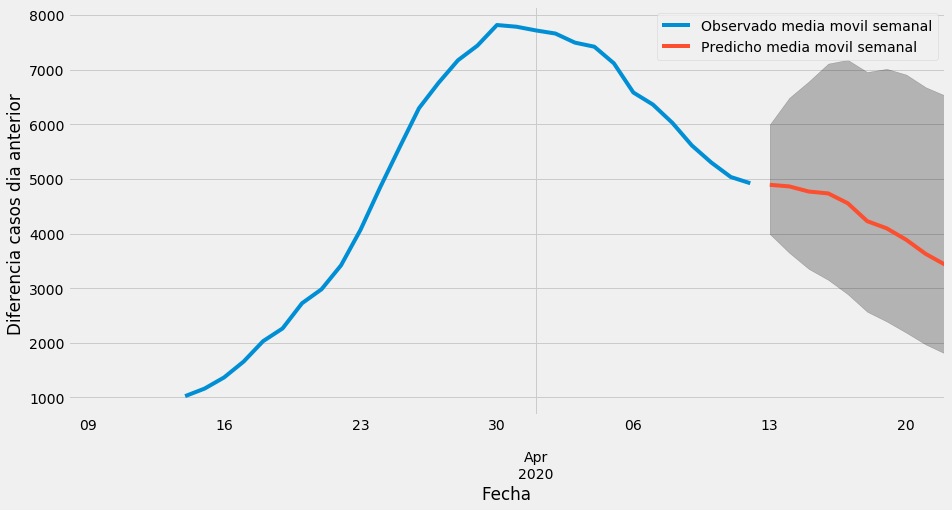

In [704]:
pred_uc = results.get_forecast(steps=10)

pred_ci = pred_uc.conf_int()
pred_ci = math.e**pred_ci
pred_uc = math.e**pred_uc.predicted_mean
ax = data_sem["Diferencia casos dia anterior"].plot(label='Observado media movil semanal', figsize=(14, 7))
pred_uc.plot(ax=ax, label='Predicho media movil semanal')
print(pred_uc)
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Fecha')
ax.set_ylabel('Diferencia casos dia anterior ')
plt.legend()
plt.show()

In [705]:
from statsmodels.formula.api import ols
data_mad= data_mad[data_mad["fecha_informe"] == data_mad["fecha_informe"].max()]
results = ols('tasa_incidencia_acumulada_total ~ data_mad["Renta Categorical"] ', data=data_mad).fit()
table = sm.stats.anova_lm(results)
table

,df,sum_sq,mean_sq,F,PR(>F)
"data_mad[""Renta Categorical""]",4.0,6.476488e+05,161912.189810,2.684711,0.036816
Residual,84.0,5.065955e+06,60308.984845,NaN,NaN


In [706]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                   OLS Regression Results                                  
===========================================================================================
Dep. Variable:     tasa_incidencia_acumulada_total   R-squared:                       0.113
Model:                                         OLS   Adj. R-squared:                  0.071
Method:                              Least Squares   F-statistic:                     2.685
Date:                             Mon, 13 Apr 2020   Prob (F-statistic):             0.0368
Time:                                     14:59:42   Log-Likelihood:                -613.53
No. Observations:                               89   AIC:                             1237.
Df Residuals:                                   84   BIC:                             1250.
Df Model:                                        4                                         
Covariance Type:                         nonrobust                                         
======================================================================================================================
                                                         coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------
Intercept                                            640.3465     59.562     10.751      0.000     521.902     758.791
data_mad["Renta Categorical"][T.Renta Baja]          124.4390     95.027      1.310      0.194     -64.534     313.412
data_mad["Renta Categorical"][T.Renta Media-Alta]    -54.4895     90.481     -0.602      0.549    -234.420     125.441
data_mad["Renta Categorical"][T.Renta Media-Baja]    -41.2813     78.548     -0.526      0.601    -197.482     114.919
data_mad["Renta Categorical"][T.Renta Media-Media]  -153.8337     77.201     -1.993      0.050    -307.356      -0.312
==============================================================================
Omnibus:                       11.349   Durbin-Watson:                   1.433
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               11.736
Skew:                           0.858   Prob(JB):                      0.00283
Kurtosis:                       3.469   Cond. No.                         6.08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""